# T-SNE Visualization Tool

## 1) Create basis trajectories 

In [232]:
import numpy as np
import os
import sys
sys.path.append(os.path.abspath('../'))

from environments.gym_parser import parse_gym_environment
from rl_algorithms import rockAgent, paperAgent, scissorsAgent, randomAgent

def RPSenv():
    import gym
    import gym_rock_paper_scissors
    return gym.make('RockPaperScissors-v0')

def RPSTask(RPSenv):
    return parse_gym_environment(RPSenv)


In [233]:
from tqdm import tqdm
from multiagent_loops import simultaneous_action_rl_loop


def collect_basis_trajectories_for(env, agents, fixed_opponents, nbr_episodes_matchup):
    trajs = {'agent':[],
                'opponent':[],
                'trajectory':[]
                }
    
    progress_bar = tqdm(range(len(fixed_opponents)))
    for e in progress_bar:
        fixed_opponent = fixed_opponents[e]
        for agent in agents:
            trajectories = simulate(env, agent, fixed_opponent, episodes=nbr_episodes_matchup, training=False)
            for t in trajectories:
                trajs['agent'].append( fixed_opponent.name)
                trajs['opponent'].append( agent.name)
                trajs['trajectory'].append( t)
        progress_bar.set_description(f'Collecting trajectories: {agent.name} against {fixed_opponent.name}.')
    return trajs

def simulate(env, agent, fixed_opponent, episodes, training):
    agent_vector = [agent, fixed_opponent]
    trajectories = list()
    mode = 'Training' if training else 'Inference'
    progress_bar = tqdm(range(episodes))
    for e in progress_bar:
        trajectory = simultaneous_action_rl_loop.run_episode(env, agent_vector, training=training)
        trajectories.append(trajectory)
        progress_bar.set_description(f'{mode} {agent.name} against {fixed_opponent.name}')
    return trajectories


In [290]:
trajectories = collect_basis_trajectories_for(RPSenv(), 
                                              [randomAgent],
                                             [rockAgent, paperAgent, scissorsAgent, randomAgent],
                                             nbr_episodes_matchup=400)

Inference RandomAgent against RockAgent:  18%|█▊        | 72/400 [00:00<00:02, 153.44it/s]


Inference RandomAgent against RockAgent:  39%|███▉      | 156/400 [00:00<00:01, 180.53it/s]


Inference RandomAgent against RockAgent:  60%|██████    | 241/400 [00:01<00:00, 186.07it/s]


Inference RandomAgent against RockAgent:  82%|████████▏ | 327/400 [00:01<00:00, 194.06it/s]


Inference RandomAgent against PaperAgent:   0%|          | 0/400 [00:00<?, ?it/s]


Inference RandomAgent against PaperAgent:  24%|██▎       | 94/400 [00:00<00:01, 226.48it/s]


Inference RandomAgent against PaperAgent:  40%|████      | 160/400 [00:00<00:01, 203.69it/s]


Inference RandomAgent against PaperAgent:  59%|█████▉    | 237/400 [00:01<00:00, 208.80it/s]


Inference RandomAgent against PaperAgent:  84%|████████▍ | 335/400 [00:01<00:00, 223.47it/s]


Inference RandomAgent against ScissorsAgent:   0%|          | 0/400 [00:00<?, ?it/s]


Inference RandomAgent against ScissorsAgent:  25%|██▍       | 99/400 [00:00<00:01, 229.23it/s]


Inference RandomAgent against ScissorsAgent:  43%|████▎     | 171/400 [00:00<00:01, 218.52it/s]


Inference RandomAgent against ScissorsAgent:  64%|██████▍   | 258/400 [00:01<00:00, 219.92it/s]


Inference RandomAgent against ScissorsAgent:  84%|████████▍ | 335/400 [00:01<00:00, 223.45it/s]


Inference RandomAgent against RandomAgent:   0%|          | 0/400 [00:00<?, ?it/s]


Inference RandomAgent against RandomAgent:  23%|██▎       | 91/400 [00:00<00:01, 195.65it/s]


Inference RandomAgent against RandomAgent:  46%|████▌     | 182/400 [00:00<00:00, 222.57it/s]


Inference RandomAgent against RandomAgent:  66%|██████▌   | 262/400 [00:01<00:00, 232.08it/s]


Inference RandomAgent against RandomAgent:  80%|███████▉  | 318/400 [00:01<00:00, 222.84it/s]


Inference RandomAgent against RandomAgent:  99%|█████████▉| 397/400 [00:01<00:00, 236.90it/s]


In [291]:
trajectories.keys()


dict_keys(['agent', 'opponent', 'trajectory'])

In [292]:
len(trajectories['trajectory'])


1600

## 2) Encode trajectories

In [293]:
import copy
ts = copy.deepcopy(trajectories['trajectory'])
print(f'Nbr traj: {len(ts)} // Steps per traj: {len(ts[0])} // Elements per steps: {len(ts[0][0])}')

Nbr traj: 1600 // Steps per traj: 10 // Elements per steps: 5


In [294]:
a0 = ts[0][0][1]
print(a0)

[0, 0]


In [295]:
#actions = [ [step[1] for idx, step in enumerate(t) if idx<3]for t in ts]
actions = [ [step[1] for idx, step in enumerate(t) if idx<10]for t in ts]

In [296]:
actions = np.asarray(actions)
actions.shape

(1600, 10, 2)

In [297]:
x_actions = copy.deepcopy(actions)
y_agents = np.asarray( copy.deepcopy(trajectories['agent']) )
print(x_actions.shape, y_agents.shape)

(1600, 10, 2) (1600,)


In [298]:
import pickle
data_dir = './data'
x_actions_dir = './x_actions'
y_agents_dir = './y_agents'
pickle.dump( trajectories, open(data_dir, 'wb'))
pickle.dump( x_actions, open(x_actions_dir, 'wb'))
pickle.dump( y_agents, open(y_agents_dir, 'wb'))

## 3) Create t-SNE

In [299]:
from sklearn.manifold import TSNE

In [300]:
n_dims = 2
shuffle = True
if shuffle:
    p = np.random.permutation(len(x_actions))
    x_actions = x_actions[p]
    y_agents = y_agents[p]

X_sample_flat = np.reshape(x_actions, [x_actions.shape[0], -1])
perplexities = [5, 30, 50, 100, 200,500,600]
#embeddings = TSNE(n_components=n_dims, init='pca', random_state=17, verbose=2, perplexity=perplexities[1]).fit_transform(X_sample_flat)
embeddings = TSNE(n_components=n_dims, 
                  init='pca',
                  #init='random', 
                  random_state=17, 
                  verbose=2, 
                  learning_rate=700,
                  n_iter=1000,
                  perplexity=perplexities[5]
                 ).fit_transform(X_sample_flat)


[t-SNE] Computing 1501 nearest neighbors...
[t-SNE] Indexed 1600 samples in 0.000s...
[t-SNE] Computed neighbors for 1600 samples in 0.241s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1600
[t-SNE] Computed conditional probabilities for sample 1600 / 1600
[t-SNE] Mean sigma: 2.075137
[t-SNE] Computed conditional probabilities in 1.655s
[t-SNE] Iteration 50: error = 52.2983627, gradient norm = 0.2531300 (50 iterations in 1.952s)
[t-SNE] Iteration 100: error = 55.3297768, gradient norm = 0.2284053 (50 iterations in 1.906s)
[t-SNE] Iteration 150: error = 55.0980072, gradient norm = 0.2265465 (50 iterations in 1.943s)
[t-SNE] Iteration 200: error = 55.8951759, gradient norm = 0.2255163 (50 iterations in 1.972s)
[t-SNE] Iteration 250: error = 54.8917770, gradient norm = 0.2247066 (50 iterations in 2.086s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.891777
[t-SNE] Iteration 300: error = 0.4466861, gradient norm = 0.0019153 (50 iterations in 2.053

In [301]:
embeddings_dir = './embedding'
pickle.dump(embeddings, open(embeddings_dir, "wb"))

## Plot

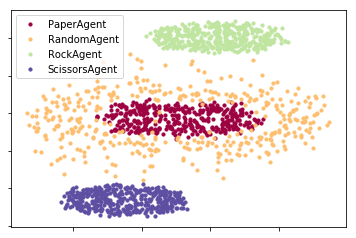

In [302]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.ticker import NullFormatter

plot_dir = './plot-t-sne'

num_classes = len(np.unique(y_agents))
labels = np.unique(y_agents)
y_sample = copy.deepcopy(y_agents)

fig = plt.figure()
ax = fig.add_subplot(111)
colors = cm.Spectral(np.linspace(0, 1, num_classes))

xx = embeddings[:, 0]
yy = embeddings[:, 1]

# plot the 2D data points
for idx, label in enumerate(labels):
    ax.scatter(xx[y_sample==label], yy[y_sample==label], color=colors[idx], label=label, s=10)

ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')
plt.legend(loc='best', scatterpoints=1, fontsize=10)
plt.savefig(plot_dir+'.pdf', format='pdf', dpi=1000)
plt.savefig(plot_dir+'.png', format='png', dpi=1000)
plt.show()
